In [1]:
! pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


### 20 superclasses of CIFAR-100 on CNN

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Device configuration
if torch.device("cuda"):
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(device)


# Hyper-parameters 
num_epochs = 100
batch_size = 64
learning_rate = 0.01

# Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset with only the 20 superclasses
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                              download=True, transform=transform)

# Filter the dataset to include only the 20 superclasses
train_dataset.data = train_dataset.data[np.array(train_dataset.targets) < 20]
train_dataset.targets = [label % 20 for label in train_dataset.targets if label < 20]
test_dataset.data = test_dataset.data[np.array(test_dataset.targets) < 20]
test_dataset.targets = [label % 20 for label in test_dataset.targets if label < 20]


# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class ConvNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout layer
        
        # Adjusted the input size based on the output of the last pooling layer
        self.fc1 = nn.Linear(512 * 4 * 4, 20)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.dropout1(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.dropout2(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # pool3_output_shape = x.shape  # Get the shape of the output after pool3
        # print("Output shape after pool3:", pool3_output_shape)
        
        x = self.bn3(x)
        x = self.dropout3(x)  # Apply dropout after the activation function
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc1(x)
        return x



# Model initialization and transfer to device
model = ConvNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * images.size(0)
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(test_loader.dataset)
    val_acc = correct / total

    # Print epoch statistics
    print(f'Epoch[{epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch[0], Train Loss: 2.4350, Val Loss: 4.0753, Train Acc: 0.2804, Val Acc: 0.0870
Epoch[1], Train Loss: 2.0684, Val Loss: 3.4386, Train Acc: 0.3883, Val Acc: 0.1425
Epoch[2], Train Loss: 1.9431, Val Loss: 2.9634, Train Acc: 0.4261, Val Acc: 0.2560
Epoch[3], Train Loss: 1.8563, Val Loss: 2.4428, Train Acc: 0.4552, Val Acc: 0.3655
Epoch[4], Train Loss: 1.7609, Val Loss: 2.5963, Train Acc: 0.4811, Val Acc: 0.3315
Epoch[5], Train Loss: 1.7430, Val Loss: 2.3734, Train Acc: 0.4853, Val Acc: 0.3905
Epoch[6], Train Loss: 1.6767, Val Loss: 2.1582, Train Acc: 0.5060, Val Acc: 0.4240
Epoch[7], Train Loss: 1.6177, Val Loss: 2.0426, Train Acc: 0.5198, Val Acc: 0.4470
Epoch[8], Train Loss: 1.5878, Val Loss: 1.8627, Train Acc: 0.5360, Val Acc: 0.4740
Epoch[9], Train Loss: 1.5446, Val Loss: 1.9942, Train Acc: 0.5406, Val Acc: 0.4475
Epoch[10], Train Loss: 1.5040, Val Loss: 1.6846, Train Acc: 0.5590, Val Acc: 0.5325
Epoch

### 100 classes on CNN

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Train Loss: 3.3948, Train Acc: 0.2176, Val Loss: 2.7832, Val Acc: 0.3051
Epoch [2/15], Train Loss: 2.5546, Train Acc: 0.3570, Val Loss: 2.4571, Val Acc: 0.3788
Epoch [3/15], Train Loss: 2.2785, Train Acc: 0.4166, Val Loss: 2.2634, Val Acc: 0.4174
Epoch [4/15], Train Loss: 2.1077, Train Acc: 0.4525, Val Loss: 2.2319, Val Acc: 0.4283
Epoch [5/15], Train Loss: 1.9836, Train Acc: 0.4817, Val Loss: 2.1555, Val Acc: 0.4475
Epoch [6/15], Train Loss: 1.8969, Train Acc: 0.4978, Val Loss: 2.0780, Val Acc: 0.4601
Epoch [7/15], Train Loss: 1.8259, Train Acc: 0.5128, Val Loss: 2.0596, Val Acc: 0.4733
Epoch [8/15], Train Loss: 1.7595, Train Acc: 0.5303, Val Loss: 2.0455, Val Acc: 0.4742
Epoch [9/15], Train Loss: 1.6992, Train Acc: 0.5465, Val Loss: 2.0494, Val Acc: 0.4750
Epoch [10/15], Train Loss: 1.6523, Train Acc: 0.5551, Val Loss: 1.9904, Val Acc: 0.4906
Epoch [11/15], Train Loss: 1.6131, Train Acc: 0.5655,

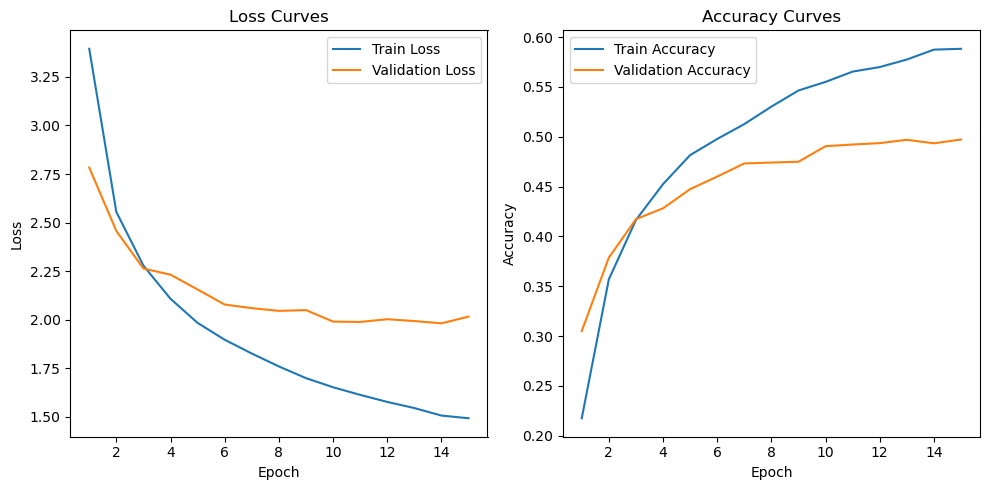

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 15
batch_size = 64
learning_rate = 0.01

# Transformation for data preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 100)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc1(x)
        return x

# Initialize the model
model = ConvNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Train the model
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images.size(0)
        
        # Track training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Calculate average training loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    
    # Append to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track validation loss
            val_loss += loss.item() * images.size(0)
            
            # Track validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Calculate average validation loss and accuracy
    val_loss /= len(test_loader.dataset)
    val_accuracy = correct_val / total_val
    
    # Append to lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()


### 20 Superclasses with Regularization

cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100], Train Accuracy: 28.38%, Validation Accuracy: 12.90%
Epoch [2/100], Train Accuracy: 38.41%, Validation Accuracy: 17.20%
Epoch [3/100], Train Accuracy: 42.54%, Validation Accuracy: 20.30%
Epoch [4/100], Train Accuracy: 44.97%, Validation Accuracy: 28.15%
Epoch [5/100], Train Accuracy: 47.69%, Validation Accuracy: 31.45%
Epoch [6/100], Train Accuracy: 50.01%, Validation Accuracy: 40.05%
Epoch [7/100], Train Accuracy: 50.01%, Validation Accuracy: 40.75%
Epoch [8/100], Train Accuracy: 51.52%, Validation Accuracy: 41.10%
Epoch [9/100], Train Accuracy: 53.49%, Validation Accuracy: 47.15%
Epoch [10/100], Train Accuracy: 54.39%, Validation Accuracy: 43.30%
Epoch [11/100], Train Accuracy: 55.95%, Validation Accuracy: 47.65%
Epoch [12/100], Train Accuracy: 56.91%, Validation Accuracy: 50.25%
Epoch [13/100], Train Accuracy: 57.39%, Validation Accuracy: 55.00%
Epoch [14/100], Train Accuracy: 58.65%, Vali

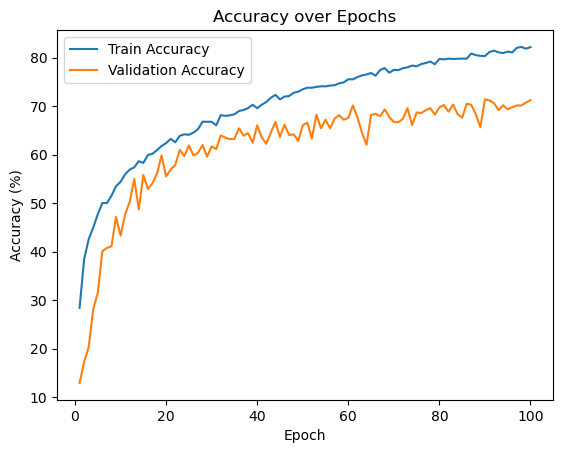

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyper-parameters 
num_epochs = 100
batch_size = 64
learning_rate = 0.01

# Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset with only the 20 superclasses
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                              download=True, transform=transform)

# Filter the dataset to include only the 20 superclasses
train_dataset.data = train_dataset.data[np.array(train_dataset.targets) < 20]
train_dataset.targets = [label % 20 for label in train_dataset.targets if label < 20]
test_dataset.data = test_dataset.data[np.array(test_dataset.targets) < 20]
test_dataset.targets = [label % 20 for label in test_dataset.targets if label < 20]

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class ConvNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout layer
        
        # Adjusted the input size based on the output of the last pooling layer
        self.fc1 = nn.Linear(512 * 4 * 4, 20)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.dropout1(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.dropout2(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.bn3(x)
        x = self.dropout3(x)  # Apply dropout after the activation function
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc1(x)
        return x

# Model initialization and transfer to device
model = ConvNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Lists to store accuracy over epochs
train_accuracy_list = []
val_accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Counting total and correct predictions
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calculating training accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Counting total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculating validation accuracy
    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting accuracy over epochs
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

### 20 classes with regularization

cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/250], Train Accuracy: 28.18%, Validation Accuracy: 15.15%
Epoch [2/250], Train Accuracy: 38.25%, Validation Accuracy: 15.10%
Epoch [3/250], Train Accuracy: 41.52%, Validation Accuracy: 30.05%
Epoch [4/250], Train Accuracy: 45.36%, Validation Accuracy: 22.75%
Epoch [5/250], Train Accuracy: 46.97%, Validation Accuracy: 25.10%
Epoch [6/250], Train Accuracy: 48.44%, Validation Accuracy: 33.40%
Epoch [7/250], Train Accuracy: 50.91%, Validation Accuracy: 38.50%
Epoch [8/250], Train Accuracy: 52.37%, Validation Accuracy: 42.30%
Epoch [9/250], Train Accuracy: 52.79%, Validation Accuracy: 47.40%
Epoch [10/250], Train Accuracy: 53.80%, Validation Accuracy: 47.80%
Epoch [11/250], Train Accuracy: 56.38%, Validation Accuracy: 46.75%
Epoch [12/250], Train Accuracy: 56.42%, Validation Accuracy: 42.50%
Epoch [13/250], Train Accuracy: 57.84%, Validation Accuracy: 50.95%
Epoch [14/250], Train Accuracy: 58.04%, Vali

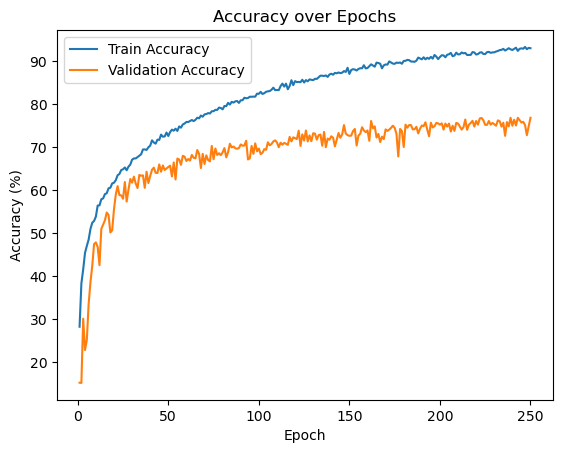

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyper-parameters 
num_epochs = 250
batch_size = 64
learning_rate = 0.01

# Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset with only the 20 superclasses
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                              download=True, transform=transform)

# Filter the dataset to include only the 20 superclasses
train_dataset.data = train_dataset.data[np.array(train_dataset.targets) < 20]
train_dataset.targets = [label % 20 for label in train_dataset.targets if label < 20]
test_dataset.data = test_dataset.data[np.array(test_dataset.targets) < 20]
test_dataset.targets = [label % 20 for label in test_dataset.targets if label < 20]

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class ConvNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout layer
        
        # Adjusted the input size based on the output of the last pooling layer
        self.fc1 = nn.Linear(512 * 4 * 4, 20)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.dropout1(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.dropout2(x)  # Apply dropout after the activation function
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.bn3(x)
        x = self.dropout3(x)  # Apply dropout after the activation function
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc1(x)
        return x

# Model initialization and transfer to device
model = ConvNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Lists to store accuracy over epochs
train_accuracy_list = []
val_accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Counting total and correct predictions
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calculating training accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Counting total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculating validation accuracy
    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting accuracy over epochs
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

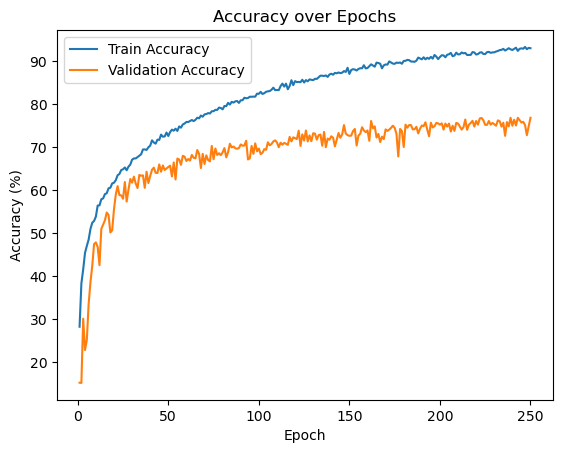

In [18]:
# Plotting accuracy over epochs
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()